In [6]:
import pandas as pd

In [10]:
df = pd.read_csv('text.txt', delimiter = "\t", header=None)

In [11]:
len(df)

4660

In [12]:
df.head()

,0
0,Elon is me presenting to a class on a project ...
1,"apple: we released a new $52,000 computer!"
2,"Elon Musk: so did we, except it's even better,..."
3,"Finally, a truck that I can draw..."
4,The glass broke because when he was hitting th...


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

nltk.download("vader_lexicon", quiet=True)

True

In [16]:
def clean_comments(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Perform data cleaning on comments to prepare for analysis
    :type dataframe: pd.DataFrame
    :param dataframe: Uncleaned dataframe for comments
    :rtype: pd.DataFrame
    :returns: Cleaned pandas dataframe
    """

    dataframe["Cleaned Comment Text"] = (
        dataframe[0]
        # remove whitespace
        .str.strip()
        # replace newlines with space
        .str.replace("\n", " ")
        # remove mentions and links
        .str.replace(r"(?:\@|http?\://|https?\://|www)\S+", "", regex=True)
        # remove punctuations, emojis, special characters
        .str.replace(r"[^\w\s]+", "", regex=True)
        # turn to lowercase
        .str.lower()
        # remove numbers
        .str.replace(r"\d+", "", regex=True)
        # remove hashtags
        .str.replace(r"#\S+", " ", regex=True)
    )

    # remove stop words
    stop_words = stopwords.words("english")
    dataframe["Cleaned Comment Text"] = dataframe["Cleaned Comment Text"].apply(
        lambda comment: " ".join([word for word in comment.split() if word not in stop_words])
    )

    return dataframe


In [17]:
cleaned_df = clean_comments(df)

In [3]:
def _get_polarity_score(analyzer: SentimentIntensityAnalyzer, text: str) -> float:
    """Calculate polarity score for the given text
    :type analyzer: SentimentIntensityAnalyzer
    :param analyzer: Sentiment analyzer for Vader model
    :type text: str
    :param text: Cleaned comment text
    :rtype: float
    :returns: Polarity score
    """

    scores = analyzer.polarity_scores(text)

    return scores["compound"]


def _convert_score_to_sentiment(score) -> str:
    """Convert score to sentiment
    :type score: float
    :param score: Polarity score
    :rtype: str
    :returns: Sentiment as Positive, Negative, or Neutral
    """

    sentiment = ""

    if score <= -0.5:
        sentiment = "Negative"
    elif -0.5 < score <= 0.5:
        sentiment = "Neutral"
    else:
        sentiment = "Positive"

    return sentiment

In [4]:

def analyze_comments(dataframe: pd.DataFrame) -> pd.DataFrame:
    """Analyze comments by calculating polarity scores
    Add Sentiment Score and Sentiment columns to the dataframe.
    :type dataframe: pd.DataFrame
    :param dataframe: Comments dataframe
    :rtype: pd.DataFrame
    :returns: Dataframe with sentiment analysis results
    """

    analyzer = SentimentIntensityAnalyzer()

    dataframe["Sentiment Score"] = dataframe["Cleaned Comment Text"].apply(
        lambda comment: _get_polarity_score(analyzer, comment)
    )

    dataframe["Sentiment"] = dataframe["Sentiment Score"].apply(
        lambda score: _convert_score_to_sentiment(score)
    )

    return dataframe

In [18]:
analyze_df = analyze_comments(cleaned_df)

In [19]:
analyze_df.head()

,0,Cleaned Comment Text,Sentiment Score,Sentiment
0,Elon is me presenting to a class on a project ...,elon presenting class project didnt know due day,0.0000,Neutral
1,"apple: we released a new $52,000 computer!",apple released new computer,0.0000,Neutral
2,"Elon Musk: so did we, except it's even better,...",elon musk except even better comes vehicle att...,0.4404,Neutral
3,"Finally, a truck that I can draw...",finally truck draw,0.0000,Neutral
4,The glass broke because when he was hitting th...,glass broke hitting door sledgehammer window f...,-0.6259,Negative


In [14]:
def create_pie_chart(dataframe: df, video_title: str, filename: str) -> None:
    """Create a pie chart for the resulting analysis
    :type dataframe: pandas.DataFrame
    :param dataframe: Comments dataframe
    :type video_title: str
    :param video_title: Video title
    :type filename: str
    :param filename: Name or absolute path of the output chart
    """

    sentiment_counts_df = dataframe["Sentiment"].value_counts().to_frame()
    sentiment_counts_df.reset_index(inplace=True)
    sentiment_counts_df.rename(columns={"index": "Sentiment", "Sentiment": "Counts"}, inplace=True)

    sentiment_counts_df = sentiment_counts_df.set_index("Sentiment")

    axis = sentiment_counts_df.plot.pie(
        y="Counts",
        ylabel="",
        figsize=(12, 12),
        fontsize=15,
        autopct="%1.1f%%",
        startangle=90,
        legend=False,
        textprops={"color": "w", "weight": "bold"},
        # colors=_get_colors(sentiment_counts_df),
        colors=['red','yellow','green'],
    )

    plt.axis("equal")

    axis.set_facecolor("black")
    axis.set_title(
        f"Sentiment Analysis Results\n{video_title}",
        fontdict={"color": "white", "fontweight": "bold", "fontsize": 16},
        linespacing=2,
        pad=30,
    )

    figure = axis.get_figure()
    figure.savefig(filename, facecolor="black", dpi=600)

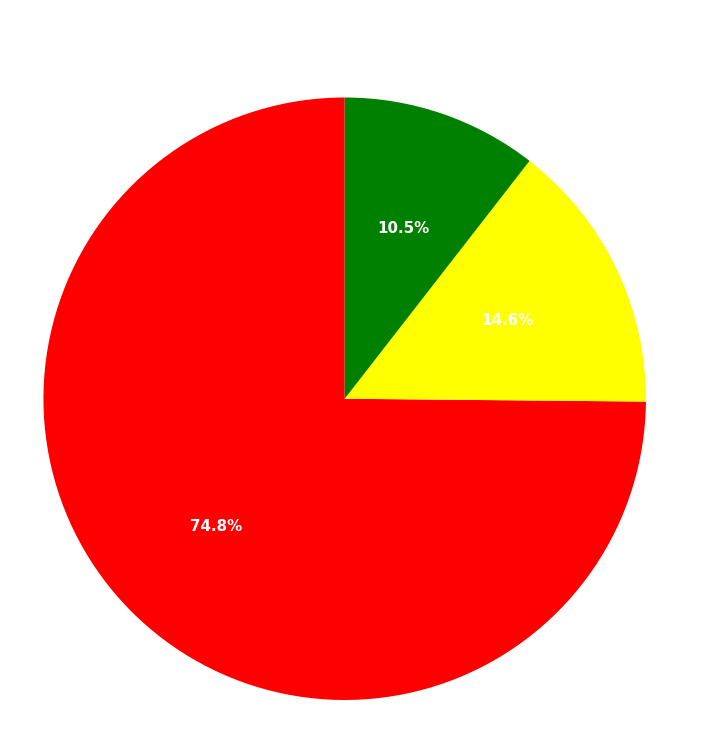

In [20]:
create_pie_chart(analyze_df, "results", "output")